In [1]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
import cv2 as cv
import cvxpy as cp
import seaborn as sns

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Question 3. Sparse Representation for Classification (34 points)
A signal not only might be sparse in an SVD or Fourier basis, but also it might be sparse in an overcomplete
dictionary whose columns consist of the training data itself. Wright et al. demonstrated the power of sparse
representation in a dictionary of test signals for robust classification of human faces, despite significant
noise and occlusions. The so-called sparse representation for classification (SRC) has been widely used in
image processing.
In this problem, you need to use two data sets. The first data set is the training set: 30 images are used for
each of 20 different people in the Yale B database, resulting in 600 columns. Notice that the first 30 columns
are the flattened images of one person, the second 30 columns are the flattened images of another person,
and so on. In the test set, there are 4 columns and each column correspond to a flatten noisy and occluded
image of 7 th person in the training set. We want to use sparse representation to classify the images that are
in test sets.


## A) 
Show the 4 images in the test set. You should be able to see that these images are noisy and occluded.

In [2]:
train = loadmat('Q3_Train.mat')['Train'] / 255.0
test = loadmat('Q3_Test.mat')['X'] / 255.0

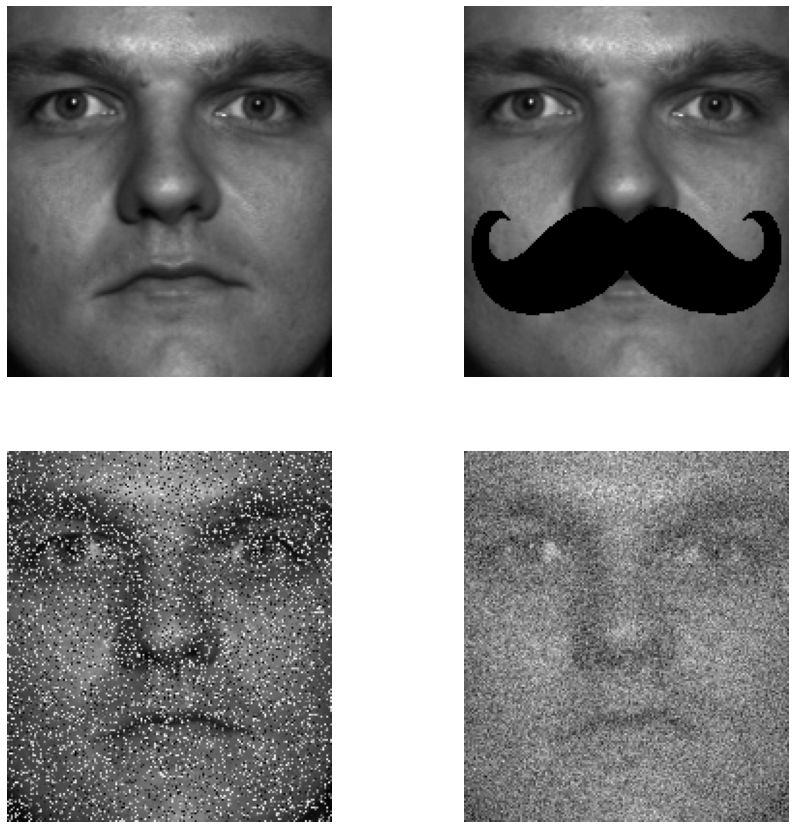

In [3]:
plt.subplots(nrows=2, ncols=2, figsize=(15,15))
plt.subplot(221)
plt.imshow(test[:,0].reshape(-1,192).T, cmap='gray')
plt.axis('off')

plt.subplot(222)
plt.imshow(test[:,1].reshape(-1,192).T, cmap='gray')
plt.axis('off')

plt.subplot(223)
plt.imshow(test[:,2].reshape(-1,192).T, cmap='gray')
plt.axis('off')

plt.subplot(224)
plt.imshow(test[:,3].reshape(-1,192).T, cmap='gray')
plt.axis('off')
plt.show()

**Here is what you should do for SRC in this problem:**

1- Use the training data set to build an overcomplete library Θ. To use compressed sensing, we need Θ to
be a fat matrix. To do so, you need to reshape each column of the training set to 192x168 image and then
resize it to 12x10, so the flattened images are 120-component vectors. You can use a built-in function to
resize the images and you should normalize each column of Θ by dividing by its norm. Notice that the
method of resizing can have an effect on your result; to get better results use the 'lanczos3' method for
resizing.

In [4]:
def resize_and_norm(col, normed=True):
    #reshape images - images are sideways in the dataset (168,192)
    img = col.reshape(168,-1)
    
    #resize image and flatten
    img = cv.resize(img, dsize=(12,10), interpolation=cv.INTER_AREA).flatten()
    
    if normed:
        #get the l2 norm of the resized image
        norm_ = norm(img,2)

        #normalize the column vector
        img = img / norm_
        
        return img, norm_
        
    return img

In [5]:
#create empty array to hold resized images
train_resized = np.empty((120, 600))

#create empty array to hold the norms for each image
train_norms = np.empty(600)

#resize and normalize train images
for col in range(600):
    col_vec, n = resize_and_norm(train[:, col])
    
    train_resized[:, col] = col_vec
    train_norms[col] = n

2- You should repeat the same process to the images in the test set: Reshape them to a 192x168 image and
resize them to 12x10. You do not need to normalize the test set.

In [6]:
#create empty array to hold resized test images
test_resized = np.empty((120, 4))

#resize test images
for col in range(4):
    col_vec = resize_and_norm(test[:,col], normed=False)
    
    test_resized[:, col] = col_vec

3- Now that you have library Θ and the test set, you can use L1 norm to find the sparse representation of
each image in the test set. To do so, you should solve the following optimization for each image in the test
set:

\begin{equation}
\text{Minimize} ||s||_1 \\
\text{s.t.} ||\Theta s - Y||_2 < e
\end{equation}



In [7]:
def optimize(theta, Y, eps):
    
    #m=120 ; n=600
    m,n = theta.shape

    #s = (600,1)
    s = cp.Variable(n)
    
    obj = cp.Minimize(cp.norm(s, 1))
    
    constraints = [
        #   theta           s         Y
        #   -----          ---       ---     =    (120,1)
        #(120 x 600) @ (600 x 1) - (120,1)
        cp.norm((theta @ s) - Y, 2) <= eps
        
    ]
    
    problem = cp.Problem(obj, constraints)
    
    problem.solve(verbose=False)
    
    return s
    
    

In [8]:
#intialize s for all 4 training images
s = np.zeros((600, 4))

In [9]:
for i in range(4):
    
    #get the sparse vector for each test i
    s_i = optimize(train_resized, test_resized[:,i], 0.9999)
 
    #cache sparse vector i
    s[:, i] = s_i.value

## B) 
Plot the 4 vectors of s separately (corresponding to each image in the test set). Ideally the resulting vector
of coefficients s should be sparse and have large coefficients primarily in the regions of the library
corresponding to the correct person in training set. Comment on whether you see large coefficients on
specific part or not.

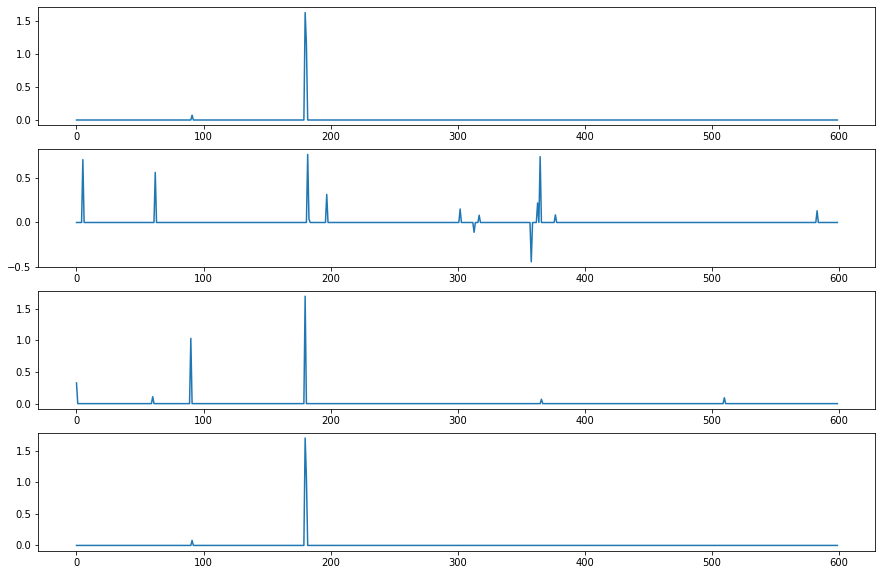

In [10]:
plt.subplots(nrows=4, ncols=1, figsize=(15,10))
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.plot(s[:,i])
plt.show()

In [11]:
for pos, i in enumerate(range(4)):
    print('Test image: {} ; Max peak: {}'.format(pos+1, np.argmax(s[:,i])))

Test image: 1 ; Max peak: 180
Test image: 2 ; Max peak: 182
Test image: 3 ; Max peak: 180
Test image: 4 ; Max peak: 180


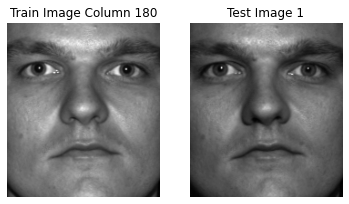

In [12]:
plt.subplots(nrows=1,ncols=2)
plt.subplot(121)
plt.imshow(train[:,180].reshape(168,-1).T, cmap='gray')
plt.axis('off')
plt.title('Train Image Column 180')
plt.subplot(122)
plt.imshow(test[:,0].reshape(168,-1).T, cmap='gray')
plt.axis('off')
plt.title('Test Image 1')
plt.show()

#### Result
The sparse vector for test image 1, 3, and 4 has a large spike for column 180 and test image 2 has a large spike for column 182. Both columns 180 and 182 of the training set correspond with the person associated with the test images

4- The final classification stage in the algorithm is achieved by computing the L2 reconstruction error using
the coefficients in the vector s vector corresponding to each of the categories separately. The category that
minimizes the L2 reconstruction error is chosen for the test image. To do that, consider a sparse
representation of an image in test set (s), then for all images corresponding to each 20 persons in the original
training set compute the following:
Error for person (j) = || [Test image(i) – (All training images of person(j) ́normalized s)] || 2 / ||Test image(i)|| 2
All the norms in the above equation are L2 norm. The result of the above equation should be 20 numbers
corresponding to the 20 persons in the training set. Normalization of s should be based on the normalizing
values that you found in part 1. Then you would classify test image(i) as person (j) if it has the minimum
error.

In [13]:
def compute_error(test_img, theta, s, norms):
    
    #initialize array to hold 20 errors for the 20 different people
    errs = np.zeros(20)
    
    for i in range(20):
        #precompute
        start = i*30
        end = (i+1)*30
        
        person = theta[:, start:end]
        s_person = s[start:end]
        norms_person = norms[start:end]
        
        #normalize sparse vectors
        s_person = s_person / norms_person
        
        #calculate error
        err = norm(test_img - person @ s_person , 2) / norm(test_img, 2)
        
        #cache error
        errs[i] = err
        
    return errs

In [14]:
#initialize empty array to cache errors
errors = []

for i in range(4):
    #for each test image, compute reconstruction error
    e = compute_error(test[:,i], train, s[:,i], train_norms)
    
    errors.append(e)

## C) 
Plot 4 bar chart correspond to 4 images in test set. In each of these bar charts, you should show the error
for person (j) in training set, so it should have 20 bars in it.

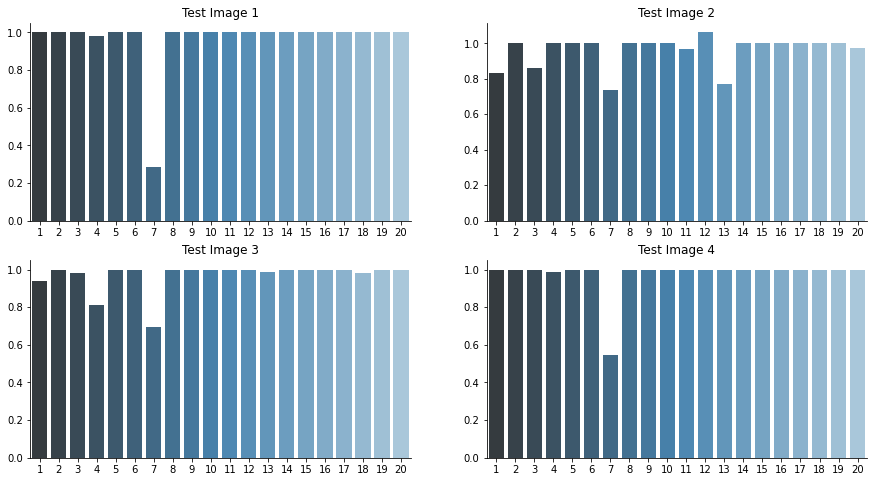

In [15]:
plt.subplots(nrows=2, ncols=2, figsize=(15,8))
for i in range(4):
    plt.subplot(2,2, i+1)
    sns.barplot(x=list(range(1,21)), y=errors[i], palette='Blues_d')
    sns.despine(top=True, right=True, left=False, bottom=False)
    plt.title('Test Image {}'.format(i+1))

plt.show()

## D)
All images in the test set are related to the 7 th person in the training set. Based on the 4 bar charts in the
previous section, determine whether or not this method was successful to classify test images.

#### Result
Based on the 4 bar charts above, the person that had the lowest reconstruction error for all 4 test images was person 7. This person is in fact the person that embodied our test images. Therefore, this method is valid with promising results